In [1]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.21.0


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Intro to PyMC

This notebook is to accompany the IAA intro to Bayes and PyMC deck. 

This notebook will walk through a few simple examples:
0. Getting data and packages
1. A naive PyMC model - basic framework
2. A simple regression model with one predictor
3. A regression model with multiple predictors

I ain't no expert. But the PyMC community is _full_ of experts. So we'll close with how to leverage them.

In [ ]:
# grabbing data
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

## 'score' is target variable

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


In [4]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Because we often need to reference the dimensions later on
N, D = X.shape

<Axes: >

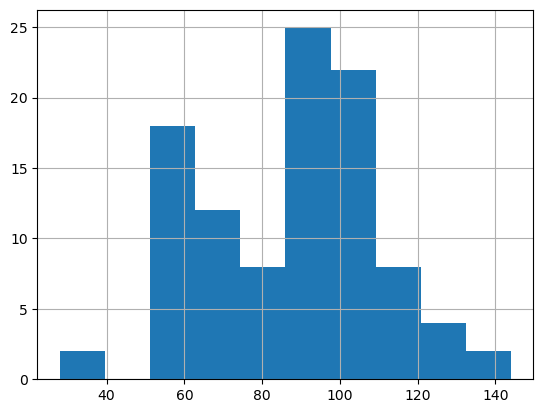

In [5]:
y.hist()

### Basic Example
Model of the standardized test score, y. 

For this version, we're just focused on the PyMC framework. We have no predictors, just a naive model. 

In [20]:
basic_model = pm.Model()

In [21]:
with basic_model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=100, sigma=20)          # assume normal w/ best guess being the average score of ~100
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # assume uniform StDev from 0 to 50 (wide b/c unknown)

    # Data generating process
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=y)

1. In the model specification, we're specifying our priors, as we have to give that directly. Then we give the data generating process, where the ```score``` is generated from a Normal distribution, centered at ```mu``` with noise defined by ```sigma```. We're not computing the likelihood here, just declaring the generative story for how the data arose - our _model_. 

2. Arviz is a powerful package to help visualize and summarize your probabilistic models. This model is pretty unintersting, but it should give you an idea of what this visual representation of the model can do, and how to interpret it. 

sample_prior_predictive() method => if we used our prior to produce the data, what would it look like?

Sampling: [mu, score, sigma]


<Axes: >

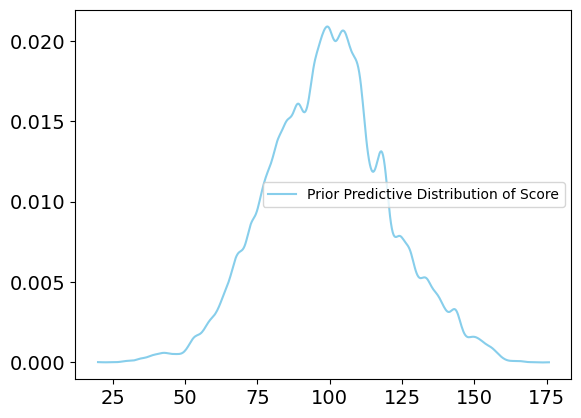

In [ ]:
with basic_model:
    # Draw samples from the prior predictive distribution
    prior_pred = pm.sample_prior_predictive(samples=500)

# Use ArviZ to visualize the distribution of `score`
az.plot_dist(prior_pred.prior_predictive['score'], 
             label='Prior Predictive Distribution of Score',
             color='skyblue')


# can use the shape of this distribution to adjust priors if values of 
# prior_pred are unreasonable / too narrow or wide

In [ ]:
pm.model_to_graphviz(basic_model)

# super helpful to sanity check our model structure
# https://graphviz.readthedocs.io/en/stable/manual.html

In [ ]:
with basic_model:
    # draw posterior samples, all defaults
    idata = pm.sample()

In [ ]:
az.summary(idata)

In [ ]:
az.plot_trace(idata, combined=True)

### Simple Regression with One Predictor

Here we're adding a predictor variable. So we want to formulate our model mathematically, then we can specify that model in PyMC and sample to our heart's content. 

\[
\begin{aligned}
\text{score}_i &\sim \mathcal{N}(\mu_i,\ \sigma) \\
\alpha &\sim \mathcal{N}(100,\ 50) \\
\beta &\sim \mathcal{N}(0,\ 10) \\
\sigma &\sim \text{HalfNormal}(25) \\
\mu_i &= \alpha + \beta \cdot \text{sibling}_i \\
\end{aligned}
\]

In [ ]:
X['siblings'].values

In [82]:

with pm.Model() as simple_model:
    #Priors
    alpha = pm.Normal('alpha', mu=100, sigma=50)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=25)

    # Linear model
    mu = alpha + beta * X['siblings'].values

    # Data generating process
    score = pm.Normal('score', mu=mu, sigma=sigma, observed=y)

In [ ]:
pm.model_to_graphviz(simple_model)

In [ ]:
with simple_model:
    idata_simple = pm.sample()

## Multiple Regression Model


We model the test score as a linear combination of multiple predictors. The model is:

\[
\begin{aligned}
\text{score}_i &\sim \mathcal{N}(\mu_i,\ \sigma) \\
\alpha &\sim \mathcal{N}(100,\ 50) \\
\beta_j &\sim \mathcal{N}(0,\ 10) \quad \text{for each predictor } j \\
\sigma &\sim \text{HalfNormal}(25) \\
\mu_i &= \alpha + \sum_{j=1}^D \beta_j \cdot x_{ij} \\
\end{aligned}
\]


In [125]:
coords = {"predictors": X.columns.values}

import pytensor.tensor as pt

with pm.Model(coords = coords) as multi_model:

    # Priors
    alpha = pm.Normal("alpha", mu=100, sigma=50) # intercept
    beta = pm.Normal("beta", mu=0, sigma=10, dims="predictors") # regression coefficients
    sigma = pm.Uniform("sigma", lower=0, upper=20) # error SD
    
    # linear model
    # show the one I fucked up first:
    #score = pm.Normal("score", sigma + pt.dot(X.values, beta), sigma, observed=y.values)
    score = pm.Normal("score", alpha + pt.dot(X.values, beta), sigma, observed=y.values)


In [ ]:
pm.model_to_graphviz(multi_model)

In [ ]:
with multi_model:
    idata_multi = pm.sample()

In [ ]:
az.plot_forest(idata_multi, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)


In [ ]:
az.summary(idata_multi)

In [ ]:
import statsmodels.api as sm

# Add intercept manually since statsmodels does not do it by default methinks
X_ols = sm.add_constant(X)

# Fit model
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())


# Next Steps

1. Go here for more: https://www.pymc.io/welcome.html
    * Examples, tips, links, further reading
2. Be part of the Discourse here: https://discourse.pymc.io/
3. Read "Statistical Rethinking"
4. Listen to "Learning Bayesian Statistics"

In [ ]:
from predictable_jokes import tell_joke

tell_joke(topic="Bayes")